In [1]:
import random

from src.utils import build_config, show_multiple, set_seeds, get_device
from src.models import get_model
from src.data import load_victim_data
from src import attacks

# Set the scenario
Feel free to adjust the parameters and explore some different scenarios.

Note: If DEBUG_RUN is set to True, the attacks will only do a maximum of 150 attack iterations to save time. The differences between the attacks can still be observed for some cases.

In [2]:
#DATASET = 'MNIST'
DATASET = 'CIFAR10'
#DATASET = 'Imagenet'

#MODEL = 'MLP'
MODEL = 'ViT'
#MODEL = 'ViTB16'

VICTIM_BATCHSIZE = 1
NUM_BATCHES = 3
NUM_SAMPLES = VICTIM_BATCHSIZE * NUM_BATCHES # should not exceed victim dataset size of 128

DROPOUT_RATE = 0.5 # between 0 and 1

SEED = 42
DEBUG_RUN = False

### Load victim dataset and select a few random images for demonstration

Loaded victim dataset CIFAR10 with batchsize 1. Data samples are of shape torch.Size([3, 32, 32]).
Seed was set to 42


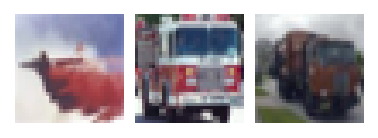

In [3]:
victim_inputs, victim_targets, data_shape = load_victim_data(f'./data/{DATASET}_128.tdump', VICTIM_BATCHSIZE)

print(f'Loaded victim dataset {DATASET} with batchsize {VICTIM_BATCHSIZE}. Data samples are of shape {data_shape}.')
#show_multiple(victim_inputs, 16, 8, img_scale=DATASET) # SHOW WHOLE VICTIM DATASET


set_seeds(SEED)
assert NUM_SAMPLES <= 128
selection = random.sample(range(len(victim_targets)), NUM_BATCHES)

selected_vicitm_inputs = [victim_inputs[i] for i in selection]
selected_vicitm_targets = [victim_targets[i] for i in selection]

original_imgs = []
for img_batch in selected_vicitm_inputs:
    original_imgs.extend(img_batch.split(1))
show_multiple(original_imgs, NUM_SAMPLES, 1, img_scale=DATASET, figsize=(NUM_SAMPLES, 1))

### Get the model

In [4]:
model_config = build_config(f'./example_configs/models/{MODEL}.yaml')
if DROPOUT_RATE is not None:
    model_config.dropout_rate = DROPOUT_RATE
model_config.data_shape = data_shape
model_config.num_classes = 1000 if DATASET == 'Imagenet' else 10
model = get_model(model_config.name, model_config)

device = get_device()
model = model.to(device)

Loaded model with VisionTransformer architecture, input shape torch.Size([3, 32, 32]), 10 classes.
Attatched MaskDropout track functionalities!
GPU : NVIDIA GeForce RTX 2080 Ti


# Attack demonstrations

## IG - baseline

In [5]:
print('IG setup:')
ig_attack_config = build_config(f'./example_configs/attacks/IG.yaml')
ig_attack_config.device = device
ig_attack_config.num_classes = 1000 if DATASET == 'Imagenet' else 10
ig_attack_config.victim_batchsize = VICTIM_BATCHSIZE
if DEBUG_RUN:
    ig_attack_config.max_iterations = 150
ig_attacker = attacks.IG(DATASET, model, selected_vicitm_inputs, selected_vicitm_targets, ig_attack_config)
print('________________________________________________________')
ig_reconstructions, ig_results = ig_attacker.attack()

IG setup:
Victim batchsize: 1
Max iterations: 20000
Using CrossEntropyLoss as model loss function.
Using GradientCosineDistance as reconstruction loss function.
________________________________________________________
Attacking victim batch 0!
Using Adam optimizer with learning rate 0.1
Using ReduceLROnPlateau as a learning rate scheduler.
Early stopping the reconstruction since we had no improvement of ReconstructionLoss for 4000 rounds.
Reconstruction was stopped after 5082 iterations for batch 0 trial 0
Execution of attack_batch took 5.19 minutes.
The reconstruction reached a MSE of 3.532104.
The reconstruction reached a best reconstruction loss of 0.3483315 after 1081 iterations.
Attacking victim batch 1!
Using Adam optimizer with learning rate 0.1
Using ReduceLROnPlateau as a learning rate scheduler.
Early stopping the reconstruction since we had no improvement of ReconstructionLoss for 4000 rounds.
Reconstruction was stopped after 5689 iterations for batch 1 trial 0
Execution of 

Results for dropout rate p=0.5:
Client victim batch 0 mean MSE:
IG: 3.532104
Client victim batch 1 mean MSE:
IG: 3.416384
Client victim batch 2 mean MSE:
IG: 3.746236
________________________________________________________
Originals:


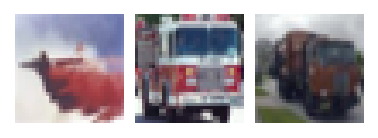

IG reconstructions:


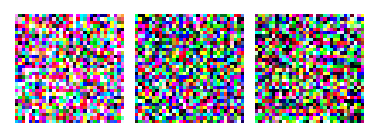

In [6]:
print(f'Results for dropout rate p={DROPOUT_RATE}:')
for i, ig_result in enumerate(ig_results):
    print(f'Client victim batch {i} mean MSE:')
    print(f'IG: {ig_result["MSE"]:.6f}')

ig_reconstructed_images = []
for b in range(NUM_BATCHES):
    ig_reconstructed_images.extend(ig_reconstructions[b]['Reconstructions'].split(1))
print('________________________________________________________')
print('Originals:')
show_multiple(original_imgs, NUM_SAMPLES, 1, img_scale = DATASET, figsize=(NUM_SAMPLES, 1))
print('IG reconstructions:')
show_multiple(ig_reconstructed_images, NUM_SAMPLES, 1, img_scale = DATASET, figsize=(NUM_SAMPLES, 1))

## Dropout Inversion Attack (DIA)
Our proposed attack joinlty optimizes for victim client data AND dropout masks to approximate the stochastic client model.

In [7]:
print('DIA setup:')
dia_attack_config = build_config(f'./example_configs/attacks/DIA.yaml')
dia_attack_config.device = device
dia_attack_config.num_classes = 1000 if DATASET == 'Imagenet' else 10
dia_attack_config.victim_batchsize = VICTIM_BATCHSIZE
if DEBUG_RUN:
    dia_attack_config.max_iterations = 150
dia_attacker = attacks.DropoutInversionAttack(DATASET, model, selected_vicitm_inputs, selected_vicitm_targets, dia_attack_config)
print('________________________________________________________')
dia_reconstructions, dia_results = dia_attacker.attack()

DIA setup:
Victim batchsize: 1
Max iterations: 20000
Using CrossEntropyLoss as model loss function.
Using GradientCosineDistance as reconstruction loss function.
________________________________________________________
Attacking victim batch 0!
Initializing dropoutmasks based on dropoutrate 0.5 with bernoulli!
Using Adam optimizer with learning rate 0.1
Using ReduceLROnPlateau as a learning rate scheduler.
Early Stopping since the reconstruction loss is extremely low.
Reconstruction was stopped after 6737 iterations for batch 0 trial 0
Execution of attack_batch took 7.94 minutes.
The reconstruction reached a MSE of 0.010410.
The reconstruction reached a best reconstruction loss of 0.0000100 after 6736 iterations.
Attacking victim batch 1!
Initializing dropoutmasks based on dropoutrate 0.5 with bernoulli!
Using Adam optimizer with learning rate 0.1
Using ReduceLROnPlateau as a learning rate scheduler.
Early Stopping since the reconstruction loss is extremely low.
Reconstruction was stop

Results for dropout rate p=0.5:
Client victim batch 0 mean MSE:
DIA: 0.010410
Client victim batch 1 mean MSE:
DIA: 0.009560
Client victim batch 2 mean MSE:
DIA: 0.014388
________________________________________________________
Originals:


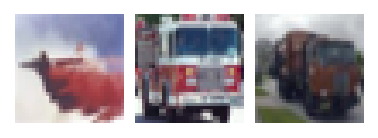

DIA reconstructions:


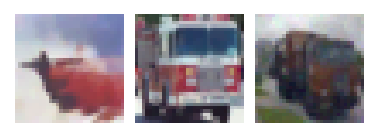

In [11]:
print(f'Results for dropout rate p={DROPOUT_RATE}:')
for i, dia_result in enumerate(dia_results):
    print(f'Client victim batch {i} mean MSE:')
    print(f'DIA: {dia_result["MSE"]:.6f}')

dia_reconstructed_images = []
for b in range(NUM_BATCHES):
    dia_reconstructed_images.extend(dia_reconstructions[b]['Reconstructions'].split(1))
print('________________________________________________________')
print('Originals:')
show_multiple(original_imgs, NUM_SAMPLES, 1, img_scale = DATASET, figsize=(NUM_SAMPLES, 1))
print('DIA reconstructions:')
show_multiple(dia_reconstructed_images, NUM_SAMPLES, 1, img_scale = DATASET, figsize=(NUM_SAMPLES, 1))

## Demonstration of WIIG (Well-Informed Inverting Gradients attack)
i.e. IG where the attacker is well-informed (has knowledge about the dropout masks, the victim client used during training).

In [9]:
print('WIIG setup:')
wiig_attack_config = build_config(f'./example_configs/attacks/WIIG.yaml')
wiig_attack_config.device = device
wiig_attack_config.num_classes = 1000 if DATASET == 'Imagenet' else 10
wiig_attack_config.victim_batchsize = VICTIM_BATCHSIZE
if DEBUG_RUN:
    wiig_attack_config.max_iterations = 150
wiig_attacker = attacks.IG(DATASET, model, selected_vicitm_inputs, selected_vicitm_targets, wiig_attack_config)
print('________________________________________________________')
wiig_reconstructions, wiig_results = wiig_attacker.attack()

WIIG setup:
Victim batchsize: 1
Max iterations: 20000
Using CrossEntropyLoss as model loss function.
Using GradientCosineDistance as reconstruction loss function.
________________________________________________________
Attacking victim batch 0!
Using Adam optimizer with learning rate 0.1
Using ReduceLROnPlateau as a learning rate scheduler.
Early Stopping since the reconstruction loss is extremely low.
Reconstruction was stopped after 102 iterations for batch 0 trial 0
Execution of attack_batch took 0.11 minutes.
The reconstruction reached a MSE of 0.005834.
The reconstruction reached a best reconstruction loss of 0.0000098 after 101 iterations.
Attacking victim batch 1!
Using Adam optimizer with learning rate 0.1
Using ReduceLROnPlateau as a learning rate scheduler.
Early Stopping since the reconstruction loss is extremely low.
Reconstruction was stopped after 922 iterations for batch 1 trial 0
Execution of attack_batch took 0.98 minutes.
The reconstruction reached a MSE of 0.003007.

Results for dropout rate p=0.5:
Client victim batch 0 mean MSE:
WIIG: 0.005834
Client victim batch 1 mean MSE:
WIIG: 0.003007
Client victim batch 2 mean MSE:
WIIG: 0.006731
_________________________________________
Originals:


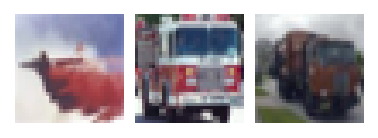

WIIG reconstructions:


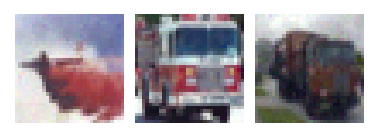

In [10]:
print(f'Results for dropout rate p={DROPOUT_RATE}:')
for i, wiig_result in enumerate(wiig_results):
    print(f'Client victim batch {i} mean MSE:')
    print(f'WIIG: {wiig_result["MSE"]:.6f}')

wiig_reconstructed_images = []
for b in range(NUM_BATCHES):
    wiig_reconstructed_images.extend(wiig_reconstructions[b]['Reconstructions'].split(1))
print('_________________________________________')
print('Originals:')
show_multiple(original_imgs, NUM_SAMPLES, 1, img_scale = DATASET, figsize=(NUM_SAMPLES, 1))
print('WIIG reconstructions:')
show_multiple(wiig_reconstructed_images, NUM_SAMPLES, 1, img_scale = DATASET, figsize=(NUM_SAMPLES, 1))